In [1]:
import numpy as np
from PIL import Image
import random
from scipy import ndarray, ndimage
import skimage.io as io
import skimage as sk
from skimage import transform
from skimage import util
import cv2
import shutil
import os
import json
from PIL import ImageDraw
from IPython.display import display
import glob
import time
import threading
import traceback
import matplotlib.pyplot as plt
import copy
from random import randint
from math import sin, cos, radians


def display(display_list):
    
    labels_list = ["Image", "Masks"]
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        
        plt.subplot(1, len(display_list), i+1)
        plt.title(labels_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


def brightness(img, brightness):
    '''
    
        Add brightness to the Image
    
    '''
    return sk.exposure.adjust_gamma(img, brightness).astype(np.uint8)




def rotatePolygon(polygon, degrees):
    """ 
    Description:
    
        Rotate polygon the given angle about its center. 
        
    Input:
        polygon (list of tuples)  : list of tuples with (x,y) cordinates 
                                    e.g [(1,2), (2,3), (4,5)]
        
        degrees int               : Rotation Degrees
    
    Output:
    
        polygon (list of tuples)  : Polygon rotated on angle(degrees)
                                e.g [(1,2), (2,3), (4,5)]
    
    """
    # Convert angle to radians
    theta = radians(degrees)  
    
    # Getting sin and cos with respect to theta
    cosang, sinang = cos(theta), sin(theta)

    # find center point of Polygon to use as pivot
    y, x = [i for i in zip(*polygon)]
    
    # find center point of Polygon to use as pivot
    n = len(x)
    cx = sum(x) / n
    cy = sum(y) / n
    
    # Rotating every point
    new_points = []
    for x, y in zip(x, y):
        tx, ty = x-cx, y-cy
        new_x = int(( tx*cosang + ty*sinang) + cx)
        new_y = int((-tx*sinang + ty*cosang) + cy)
        new_points.append((new_x, new_y))
    return new_points








def parse_via_json(json_file_path, images_dir_path):
    '''
    Description:
        Parse your json which you made from VIA-Image-Annotator. Converting your annotation to the format 
        which mrcnn support
        
    Input:
        json_file_path  (str) : Path of the json file
        images_dir_path (str) : Path of the Images Directory
        
    Output:
        images (dict) : Dictionary includes all of the images and their annotations respectively
    
    '''
    
    # Load json
    labels = json.load(open(json_file_path))['_via_img_metadata']
    
    # Seperating Keys
    keys = list(labels.keys())
    
    # Creating Images list seperately
    images = dict()
    
    
    
    # Taking key from the keys (labels)
    for key in keys:
        
        # Getting regions
        regions = labels[key]["regions"]
         
        # Getting image name
        image_name = labels[key]['filename']
        
        # Creating annotations
        annotations = dict()
        
        
        # Converting regions to mrcnn format
        for region in regions:
            try:
                
                # Getting x points
                x = region['shape_attributes']['all_points_x']
                
                # Getting y points
                y = region['shape_attributes']['all_points_y']
                
                # Getting the label names
                region_name = list(region['region_attributes']['class'].keys())[0]
                
                # Checking if label already exists (It means it another object belong to same class)
                if region_name not in annotations:
                    annotations[region_name] = [list(zip(x,y))]
                else:
                    annotations[region_name].append(list(zip(x,y)))
            
            except:
                traceback.print_exc()
                pass
         
        # Summing up all the annotations
        

        images[images_dir_path + image_name] = annotations
    
    # Return
    return images



class Augmentation:
    '''
        Doing all the work in multiprocessing
    
    
    '''
    
    def __init__(self, DIR_PATH, degree = 2):
        
        '''
            Initilizing all the variables 
        '''
        from multiprocessing.pool import ThreadPool
        
        # Creating thread pool of 32
        self.pool = ThreadPool(32)
        
        # Creating dict for augmenting images
        self.augmented_images = dict()
        
        # Checking for pending thread 
        self.pending = 0
        
        # Specefying Dir path
        self.DIR_PATH = DIR_PATH
        
        # Removing previous annotations
        shutil.rmtree(self.DIR_PATH, True)
        
        
        # Rotation degrees (Rotate every image at angle)
        self.degree = degree
        
        # creating and changing the permissions of folder created
        if not os.path.exists(self.DIR_PATH):
            os.makedirs(self.DIR_PATH, mode=0o777)

        
        
    def __del__(self):
        self.pool.close()
        self.pool.join()

        
    def callback(self, response):
        '''
            This callback fucntion initiate at the end of thread (getting the results processed by thread)
        
        '''
        
        # Getting results
        aug_image_name, response = response[0]
        
        # If thread end sucessfully than saving response
        if aug_image_name:
            self.augmented_images[aug_image_name] = response
        
        # Subtracting pending thread number
        self.pending -= 1
        
    def err(self, error):
        
        '''
        
            This fucntion initiate when any exception occurs with in a thread
        
        '''
        # Subtracting pending thread number
        self.pending -= 1
        print("Error", error)
        
        # printing exception trace-back
        traceback.print_exc()
        
        
        
    def run(self, img_path, labels):
        '''
        
            This function initiate threads
        
        '''

        try:
                # Reading Image
            img = np.asarray(Image.open(img_path))

            # Getting the width and height
            w,h = img.shape[1], img.shape[0]

            # Looping through all of the angles
                # 1. Augment images every 4 angles
            for angle in range(0, 360, self.degree):

                # Logging for thread created
                self.pending += 1

                # Getting random number for sharpness
                sharpness  = random.randint(100, 200)/100.0

                # Creating the image name
                aug_image_name = "{3}-{2}-{0}-{1}.jpg".format(angle, sharpness, random.randint(1111111,9999999), img_path.split("/")[-1])

                # Getting the save path
                save_path = self.DIR_PATH + aug_image_name  

                # Initiating thread
#                 self.r = self.pool.map_async(self.augment_image, [(img, labels, w, h, angle, sharpness, save_path)], callback=self.callback, error_callback=self.err)

#                 Only For Debugging (Sequential flow)
                
                print(img_path)
                aug_image_name,response = self.augment_image((img, labels, w, h, angle, sharpness, save_path ))
                self.augmented_images[aug_image_name] = response
        except StopIteration:
            print(f"Cannot find labels for {img_path}")
            pass
        
    def augment_image(self, args):
        '''
            This is the main fucntion which augment imagse
        
        '''
        
        # Parameters taken by the fucntion
        #         1. Pil Image : Image
        #         2. Cordinates : Cordinates of the regions
        #         3. width.     : Width of the image
        #         4. height.    : Height of the image
        #         5. angle      : angle to rotate image
        #         6. sharpness. : Scale of sharpness
        #         7. save_path. : path to save the image
        #         8. labels.    : labels according to the image
        pil_image, labels, width, height, angle, sharpness, save_path = args
        
        # Converting image to PIL object
        pil_image = Image.fromarray(pil_image)
        
        # Rotating the image
        augmented = pil_image.rotate(angle, expand = True)
        
        rotated_labels = dict() 
        for i in labels:
            print(labels[i])
            rotated_labels[i] = [rotatePolygon(i, (360 - angle)) for i in labels[i]]
        
        # Augment image
        augmented = Image.fromarray(brightness(np.asarray(augmented), random.randint(100, 200)/100.0))
        
        # Saving all of the things in response dict to save
        response = None
        if rotated_labels is not None:
            augmented.save(save_path)
            response  = rotated_labels
            aug_image_name = save_path.split("/")[-1]            
            return (aug_image_name, copy.deepcopy(response))
        else:
            return (False, False)



def save_mrcnn_labels(augmented_images,json_file_path ,classes):
    
    '''
    
        This function saves your converted annotations into a json file for training
    
    '''
    
    # Creating an empty dict to save annotations
    mrcnn_data = dict()
    
    # Creating temporary variable
    a1 = augmented_images
    
    # Getting all of the images and their augmentation
    for augmented_image in a1:
        
        # Getting the name and extension of the image
        parts = augmented_image.split(".")
        image_name, extension = ".".join(parts[:-1]), parts[-1]
        
        # Creating key for every augmented image
        key = image_name + ".json"
        mrcnn_data[key] = dict()
        mrcnn_data[key]['filename'] = image_name
        mrcnn_data[key]['file_attributes'] = dict()
        mrcnn_data[key]['regions'] = []
        
        for label in a1[augmented_image]:
            
            # Getting all x and y points
            for objects in a1[augmented_image][label]:
                all_y,all_x = [i for i in zip(*objects)]
                 
                # Creating shape attributes dict for every x and y
                region = dict()
                region["region_attributes"] = dict({"class": classes.index(label) + 1})
                region["shape_attributes"] = dict()
                region["shape_attributes"]["name"] = "polygon"
                region["shape_attributes"]["all_points_x"] = list(all_x)
                region["shape_attributes"]["all_points_y"] = list(all_y)
                mrcnn_data[key]['regions'].append(copy.deepcopy(region))

    
    # saving json
    with open(json_file_path, 'w') as f:
        json.dump(mrcnn_data, f)

In [2]:
# from image_aug_utils import Augmentation, parse_via_json, save_mrcnn_labels
from time import sleep
import numpy as np
# from utils import *

# Directory in which images exists 
DIR_PATH = "/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/"

# Json File Path
doc_labels = "/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/annotation1.json"

# Rotation angle degree (Rotate image at angle)
degrees = 360

# Parsing Json
images = parse_via_json(doc_labels, DIR_PATH)

# Getting all of the classes from your annotations 
classes = list(set([ __ for _ in images.values() for __ in list(_.keys())]))
print(classes)

# Images you are going to augment should be greater than 1
if len(images) <= 1:
    print("I need at least 2 images")
    exit()

# Spliting train and testing images
total_training = int(len(images) * 0.9)
counter = 0

# Initilzing Train and val multiprocessing augmentation class
train = Augmentation(DIR_PATH + "/train/", degrees)
val = Augmentation(DIR_PATH + "/val/", degrees)


# Creating images
print("Creating Images....")
for image_path in images:
    if  counter < total_training:

        train.run(image_path, images[image_path])
    else:
        val.run(image_path, images[image_path])
    counter += 1


# while train.pending > 0 or val.pending > 0:
#     print(f"Train Pending  :{train.pending},  Validation Pending: {val.pending}", end= '\r')
#     sleep(1)


# Saving Labels
print("Saving Labels into json")
save_mrcnn_labels(train.augmented_images, DIR_PATH + "/train/via_region_data.json", classes)
save_mrcnn_labels(val.augmented_images, DIR_PATH + "/val/via_region_data.json", classes)
file1 = open(DIR_PATH+"labels.txt","w")
write='"' + '","'.join(classes) + '"'
file1.writelines(write)
file1.close()


['feet', 'zebra_crossing']
Creating Images....
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/_101823025_abbeyroadfans.jpg
[[(85, 384), (943, 374), (969, 474), (967, 527), (12, 540), (7, 490)]]
[[(229, 417), (171, 411), (158, 442), (203, 455), (279, 445), (257, 413)], [(356, 406), (453, 408), (466, 428), (429, 445), (361, 437)], [(531, 396), (529, 396), (639, 401), (637, 442), (540, 442), (526, 406)], [(765, 396), (912, 392), (918, 428), (774, 443), (761, 413)], [(81, 341), (118, 333), (118, 352), (87, 356)], [(27, 331), (68, 322), (67, 352), (38, 356)]]
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/_105840167_img_7633.jpg
[[(155, 459), (531, 424), (864, 499), (514, 568), (276, 593)]]
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossi

/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/-pedestrian-crossing-street-photography-4e61c7dc-ea14-478a-a3e1-52f6321b8943.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/-walking-crowded-businessman-businesswoman-crosswalk-illustration_229548-231.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/00pedxing01-superJumbo.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/1UlykOptniUdrSMhcCNnFiQ.jpeg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/2.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing

/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/images306.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/images308.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/images329.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/images330.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/images331.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/images332.jpg
/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/

# Image Augmentation Validation

In [3]:
import utils
import skimage

"""Build Dataset."""
print("Loading Training Dataset...")
DATASET_DIR = DIR_PATH

# Training dataset.
dataset_train = utils.GenericDataset()
dataset_train.load_item(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
print("Loading Validation Dataset...")
dataset_val = utils.GenericDataset()
dataset_val.load_item(DATASET_DIR, "val")
dataset_val.prepare()

Loading Training Dataset...
29
Loading Validation Dataset...
0


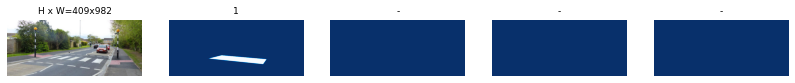

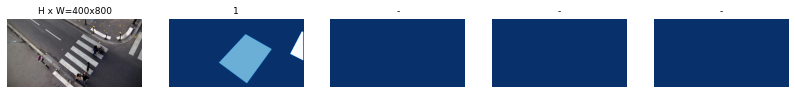

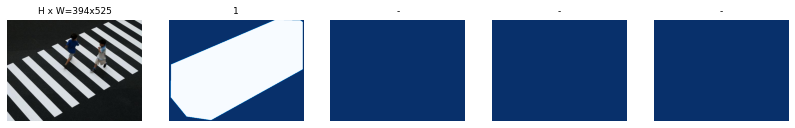

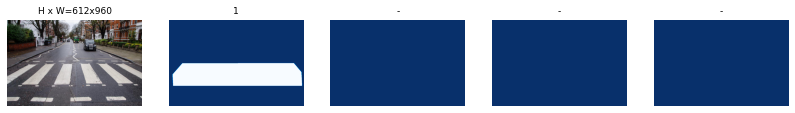

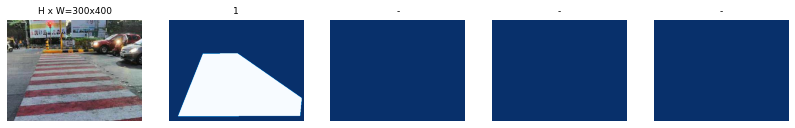

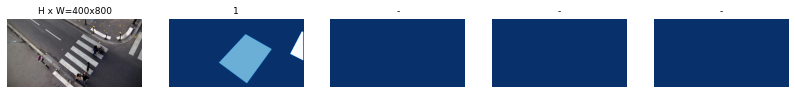

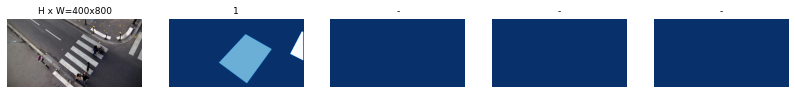

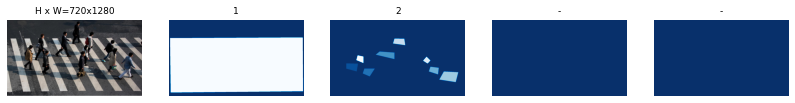

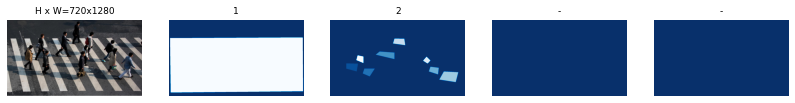

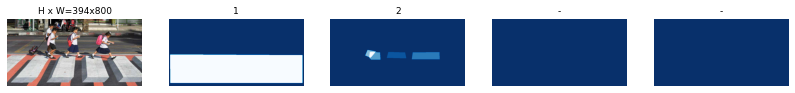

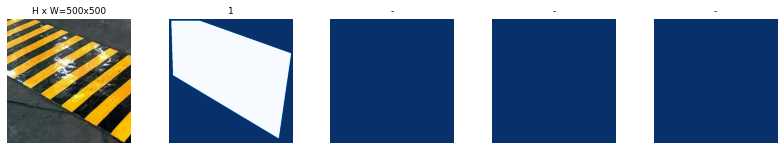

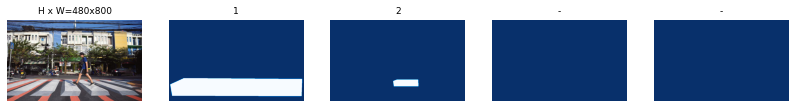

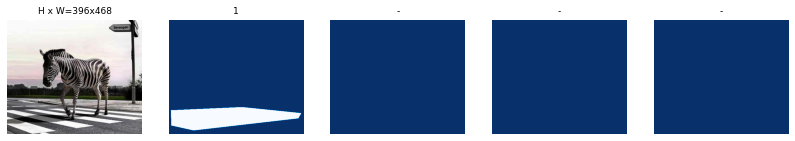

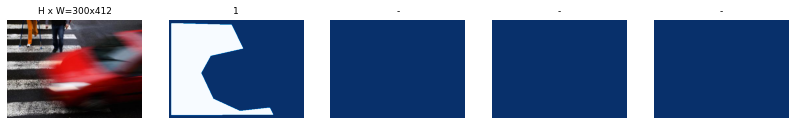

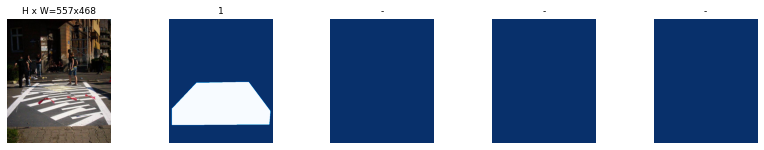

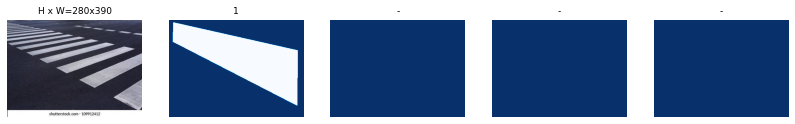

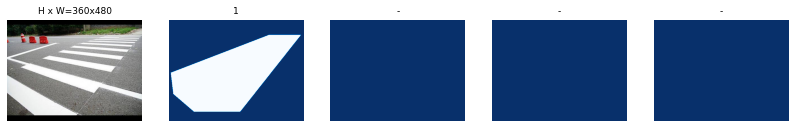

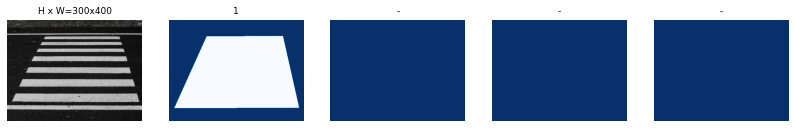

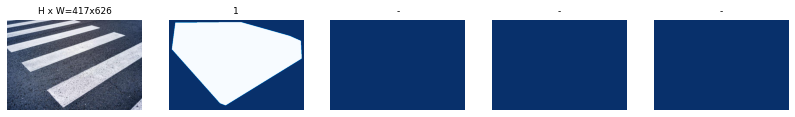

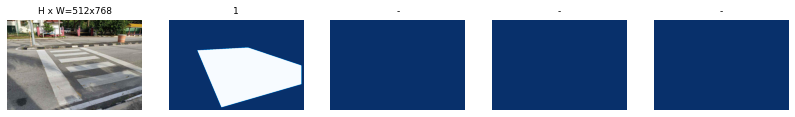

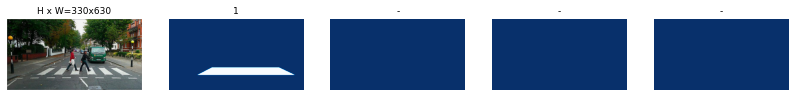

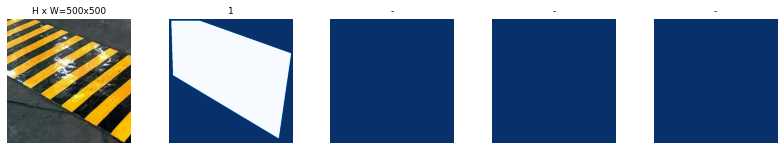

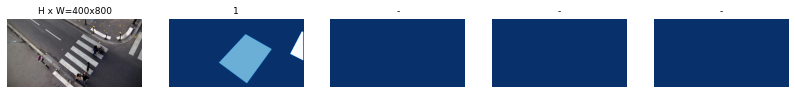

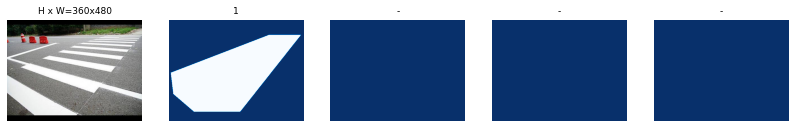

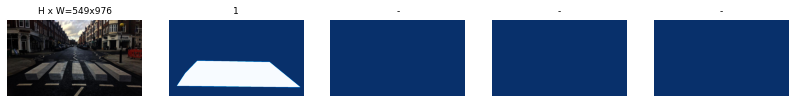

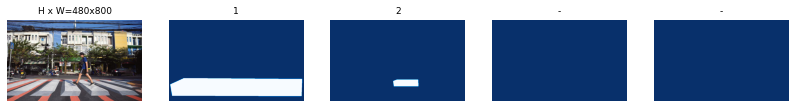

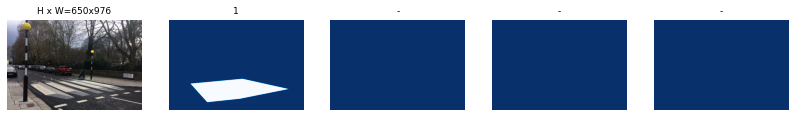

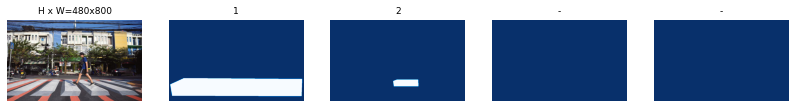

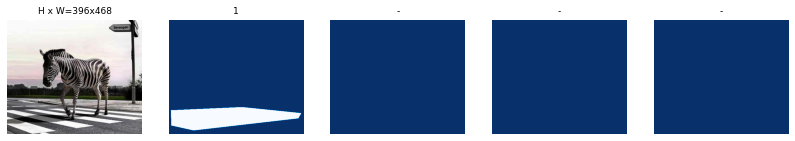

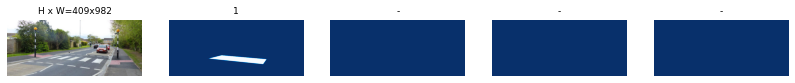

In [4]:
import visualization as vis
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 30)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    vis.display_top_masks(image, mask, class_ids,dataset_train.class_names , limit=4)

In [5]:
from PIL import Image
img = Image.open(image_path).rotate(90,expand = True)

In [6]:



polygon = [[(85, 384), (943, 374), (969, 474), (967, 527), (12, 540), (7, 490)]]
rotatePolygon(polygon[0], 90)

[(52, 578), (910, 588), (936, 488), (934, 435), (-20, 422), (-25, 472)]

In [7]:
polygon

[[(85, 384), (943, 374), (969, 474), (967, 527), (12, 540), (7, 490)]]

NotRotated [(85, 384), (943, 374), (969, 474), (967, 527), (12, 540), (7, 490)]


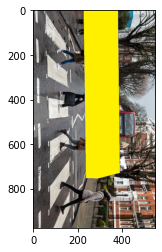

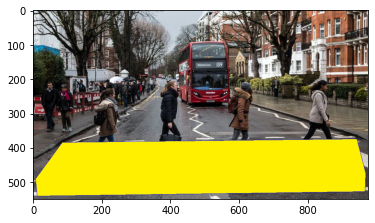

In [23]:
from math import sin, cos, radians

# def rotatePolygon(polygon, degrees):
#     """ Rotate polygon the given angle about its center. """
#     theta = radians(degrees)  # Convert angle to radians
#     cosang, sinang = cos(theta), sin(theta)

#     points = polygon.getPoints()
#     # find center point of Polygon to use as pivot
#     n = len(points)
#     cx = sum(p.getX() for p in points) / n
#     cy = sum(p.getY() for p in points) / n

#     new_points = []
#     for p in points:
#         x, y = p.getX(), p.getY()
#         tx, ty = x-cx, y-cy
#         new_x = ( tx*cosang + ty*sinang) + cx
#         new_y = (-tx*sinang + ty*cosang) + cy
#         new_points.append(Point(new_x, new_y))

#     rotated_ploygon = polygon.clone()  # clone to get current attributes
#     rotated_ploygon.points = new_points
#     return rotated_ploygon

import math
from PIL import Image, ImageDraw
from PIL import ImagePath 
from PIL import Image
import matplotlib.pyplot as plt
from math import sin, cos, radians

def rotatePolygon(polygon, degrees, height, width):
    """ 
    Description:
    
        Rotate polygon the given angle about its center. 
        
    Input:
        polygon (list of tuples)  : list of tuples with (x,y) cordinates 
                                    e.g [(1,2), (2,3), (4,5)]
        
        degrees int               : Rotation Degrees
    
    Output:
    
        polygon (list of tuples)  : Polygon rotated on angle(degrees)
                                e.g [(1,2), (2,3), (4,5)]
    
    """
    # Convert angle to radians
    theta = radians(degrees)  
    
    # Getting sin and cos with respect to theta
    cosang, sinang = cos(theta), sin(theta) 

    # find center point of Polygon to use as pivot
    y, x = [i for i in zip(*polygon)]
    
    # find center point of Polygon to use as pivot
    
    cx = width / 2
    cy = height / 2
    
    # Rotating every point
    new_points = []
    for x, y in zip(x, y):
        tx, ty = x-cx, y-cy
        new_x = (tx*cosang + ty*sinang) + cx
        new_y = (-tx*sinang + ty*cosang) + cy
        new_points.append((new_y, new_x))
    return new_points







xy = [(85, 384), (943, 374), (969, 474), (967, 527), (12, 540), (7, 490)]
degrees = 270

image_path = "/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/_101823025_abbeyroadfans.jpg"
img = Image.open(image_path)
rotated_image = img.rotate(degrees,expand = True)
h, w = img.size

print("NotRotated", xy)
rotated_xy = rotatePolygon(xy, 360 - (degrees), h, w)



# Ploting Rotated Image
img1 = ImageDraw.Draw(rotated_image)  
img1.polygon(new_xy, fill ="#FFF000", outline ="blue") 


# Ploting Straight Image
img1 = ImageDraw.Draw(img)  
img1.polygon(xy, fill ="#FFF000", outline ="blue") 

plt.imshow(rotated_image)
plt.show()


plt.imshow(img)
plt.show()

In [9]:

def rotate_box(corners, angle,  cx, cy, h, w):
    
    """
    Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW // 2) - cx
    M[1, 2] += (nH // 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
#     calculated = calculated.reshape(-1,8)
#     calculated = np.expand_dims(calculated, axis = 0)
    
#     if len(np.where(calculated[:, [0,2,4,6]] > w)) == 0 or len(np.where(calculated[:, [1,3,5,7]] > h)) == 0:
#         return None
    
    return calculated

[ 85 384 943 374 969 474 967 527  12 540   7 490]
(976, 549)
(549, 976)
[[ 598.  677.]
 [ 588. -181.]
 [ 688. -207.]
 [ 741. -205.]
 [ 754.  750.]
 [ 704.  755.]]


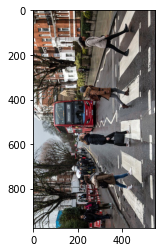

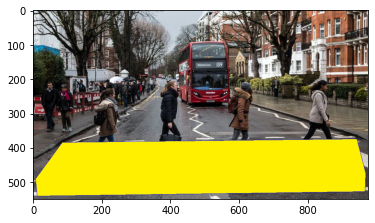

In [10]:
import cv2
import numpy as np
xy = [(85, 384), (943, 374), (969, 474), (967, 527), (12, 540), (7, 490)]

xy_list = np.asarray(([list(i) for i in xy])).flatten()
print(xy_list)

degrees = 90


image_path = "/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/_101823025_abbeyroadfans.jpg"


img = Image.open(image_path)
print(img.size)
rotated_image = img.rotate(degrees,expand = True)
print(rotated_image.size)

h, w = img.size

cy, cx = h//2, w//2

rotates_xy = rotate_box(xy_list, degrees,  cy, cx, h, w)

print(rotates_xy)
rotates_xy = [tuple(i) for i in rotates_xy]



img1 = ImageDraw.Draw(rotated_image)  
img1.polygon(rotates_xy, fill ="#FFF000", outline ="blue") 


img1 = ImageDraw.Draw(img)  
img1.polygon(xy, fill ="#FFF000", outline ="blue") 

plt.imshow(rotated_image)
plt.show()


plt.imshow(img)
plt.show()